In [1]:
import collections
from collections import OrderedDict
import pandas as pd

In [2]:
%pylab inline
rcParams['figure.figsize'] = [20, 16]

Populating the interactive namespace from numpy and matplotlib


In [3]:
run -i "windows_door_algorithm.py"

In [4]:
data_size = 500
compressor = WindowsDoorCompression(data_size)

In [5]:
df = pd.read_csv('data/sample1.csv', parse_dates=True, index_col=0)
df['Counter'] = df['Counter'].astype(float)
data = {}
data = OrderedDict(sorted(data.items(), key=lambda t: t[0]))

for index, row in df.iterrows():
    data[index] = row['Counter']

data

OrderedDict([(Timestamp('2014-08-31 15:15:00'), 800.0),
             (Timestamp('2014-08-31 15:30:00'), 685.0),
             (Timestamp('2014-08-31 15:45:00'), 642.0),
             (Timestamp('2014-08-31 16:00:00'), 637.0),
             (Timestamp('2014-08-31 16:15:00'), 648.0),
             (Timestamp('2014-08-31 16:30:00'), 802.0),
             (Timestamp('2014-08-31 16:45:00'), 804.0),
             (Timestamp('2014-08-31 17:00:00'), 814.0),
             (Timestamp('2014-08-31 17:15:00'), 646.0),
             (Timestamp('2014-08-31 17:30:00'), 628.0),
             (Timestamp('2014-08-31 17:45:00'), 628.0),
             (Timestamp('2014-08-31 18:00:00'), 641.0),
             (Timestamp('2014-08-31 18:15:00'), 615.0),
             (Timestamp('2014-08-31 18:30:00'), 607.0),
             (Timestamp('2014-08-31 18:45:00'), 618.0),
             (Timestamp('2014-08-31 19:00:00'), 625.0),
             (Timestamp('2014-08-31 19:15:00'), 635.0),
             (Timestamp('2014-08-31 19:30:00'), 

In [6]:
exception = compressor._run_exception(data)

868 1 672.6301522736643
868 1 672.6301522736643 336.81507613683215
336 337.81507613683215 672.6301522736643 505.2226142052482
496 337.81507613683215 504.2226142052482 421.0188451710402
1549683423.1247833  seconds time elapsed in running exception.
1549683423.2900448  seconds time elapsed in running exception.
0.16526150703430176  seconds time elapsed in running exception.
5974 number of data points discarded as part of exception window
496 data points remaining


In [10]:
exception_modified = {}

for time, value in exception.items():
    exception_modified[time] = [time, value]

exception_df = pd.DataFrame.from_dict(exception_modified, orient='index')
exception_df.columns = ['Date', 'Counter']
exception_df.set_index('Date', inplace=True)

ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements

In [ ]:
exception_df.plot()

In [12]:
t0 = time.time()

slope_max = +inf
slope_min = -inf

first_value_encountered = False

compression = {}

compression_window_counter = 0

last_time = exception_df.index[0]
last_value = exception_df['Counter'][0]

for index in range(len(exception_df['Counter'])):
    if math.isnan(data[index]):
        continue
    if not first_value_encountered:
        snapshot_time = exception_df.index[index]
        snapshot_value = exception_df['Counter'][index]
        
        compression[snapshot_time] = [snapshot_time, snapshot_value]
        first_value_encountered = True
        continue
    
    last_time = exception_df.index[index]
    last_value = exception_df['Counter'][index]
    
    curr_slope = (exception_df['Counter'][index] - snapshot_value) / ((exception_df.index[index] - snapshot_time).total_seconds() / 1000.0)
    
    curr_slope_max = (exception_df['Counter'][index] + compression_deviation - snapshot_value) / ((exception_df.index[index] - snapshot_time).total_seconds() * 1000)
    curr_slope_min = (exception_df['Counter'][index] - compression_deviation - snapshot_value) / ((exception_df.index[index] - snapshot_time).total_seconds() * 1000)

    slope_max = min(slope_max, curr_slope_max)
    slope_min = max(slope_min, curr_slope_min)
        
    if curr_slope < slope_min or curr_slope > slope_max:
        compression_window_counter = 0
    else:
        compression_window_counter = (compression_window_counter + 1) % compression_window_size
            
    if compression_window_counter == 0:
        if exception_df.index[index - 1] not in compression:
            compression[exception_df.index[index - 1]] =  [exception_df.index[index - 1], exception_df['Counter'][index - 1]]
        if exception_df.index[index] not in compression:
            compression[exception_df.index[index]] = [exception_df.index[index], exception_df['Counter'][index]]
        
        snapshot_time = exception_df.index[index]
        snapshot_value = exception_df['Counter'][index]

        slope_max = (exception_df['Counter'][index] + compression_deviation - exception_df['Counter'][index - 1]) / ((exception_df.index[index] - exception_df.index[index - 1]).total_seconds() * 1000)
        slope_min = (exception_df['Counter'][index] - compression_deviation - exception_df['Counter'][index - 1]) / ((exception_df.index[index] - exception_df.index[index - 1]).total_seconds() * 1000)

if last_time not in compression:
    compression[last_time] = [last_time, last_value]

    
t1 = time.time()

print("{} {}".format(t1 - t0, " seconds time elapsed"))

0.2528080940246582  seconds time elapsed


In [13]:
print("{} {}".format((len(exception) - len(compression)), "number of data points discarded as part of compression window"))


0 number of data points discarded as part of compression window


In [14]:
print("{} {}".format(len(compression), "data points remaining"))


712 data points remaining


In [15]:
compression_df = pd.DataFrame.from_dict(compression, orient='index')
compression_df.columns = ['Date', 'Counter']
compression_df.set_index('Date', inplace=True)

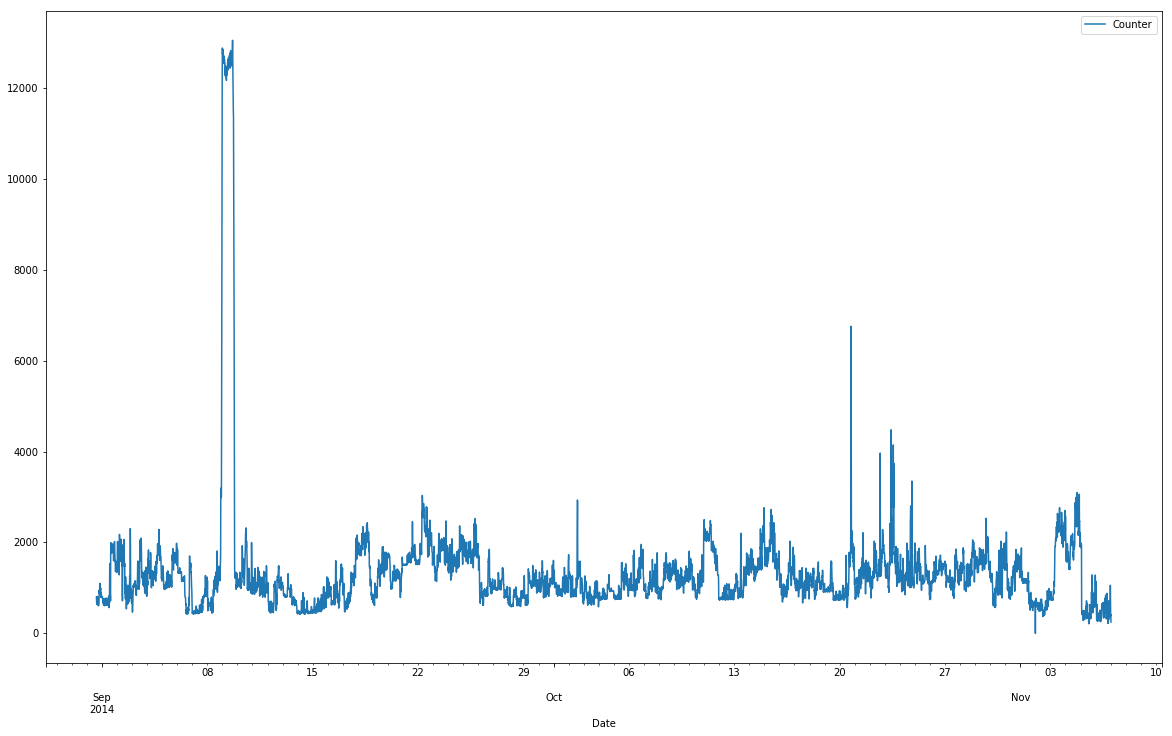

In [16]:
df.plot()

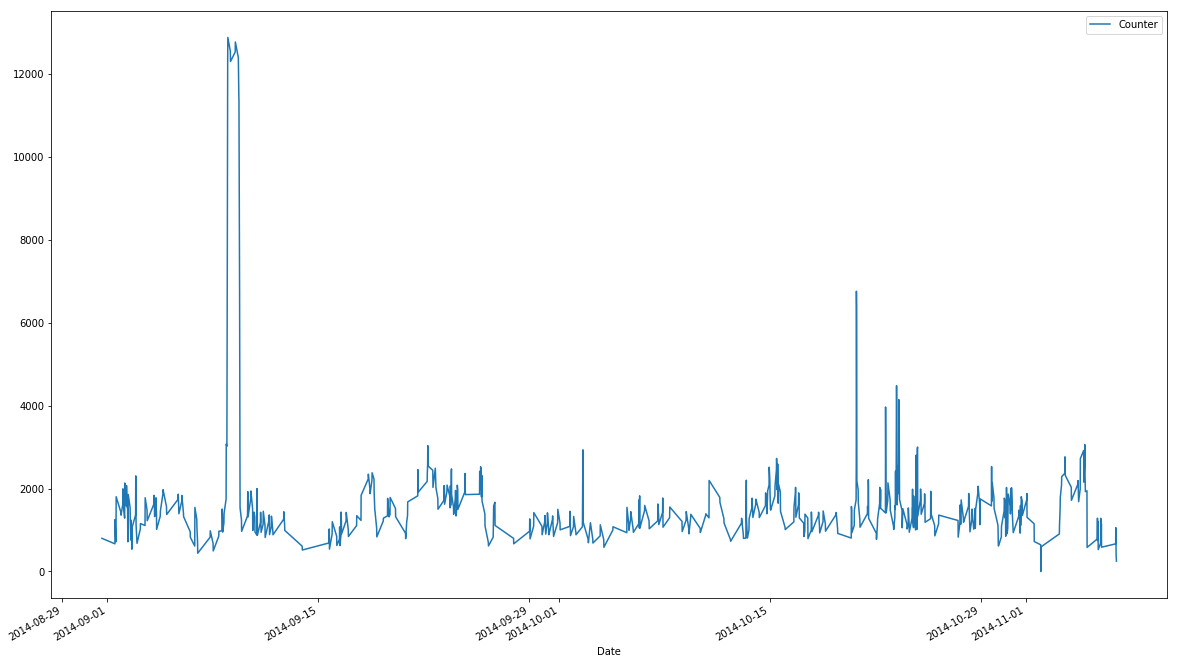

In [17]:
compression_df.plot()